# Notebook

## 1. Motivation
I wanted to explore a question that became really obvious during the pandemic: how did COVID‐19 severity and policy changes actually affect everyday life, like traffic volumes? Denmark’s early lockdowns, nimble reopenings, and high vaccination rates make it a neat case study. And since I’m a design student, I’m fascinated by how visual storytelling can turn data into a narrative that anyone can follow.

### 1.1. What is your dataset?
We’re working with three main sources:

COVID-19 data from Statens Serum Institut (SSI), giving us daily confirmed cases, hospitalizations, and deaths by region.\
https://www.ssi.dk//sygdomme-beredskab-og-forskning/sygdomsovervaagning/c/historiske-covid-19-opgoerelser 

Traffic counts from the German Federal Highway Research Institute (BASt) at the Ellund border crossing to Denmark on the A7. We roll these hourly counts into weekly anomalies versus a 2015–17 baseline.\
https://www.bast.de/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Daten/2022_1/Jawe2022.html?nn=1817946&cms_detail=1109&cms_map=0

Policy timeline (key dates for lockdowns, reopenings, vaccination milestones), stitched together from SSI press releases.\
https://www.ssi.dk/-/media/arkiv/subsites/covid19/presse/tidslinje-over-covid-19/covid-19-tidslinje-for-2020-2022-lang-version—version-1—april-2022.pdf2024 

### 1.2. Why these particular datasets?
COVID data is a direct window into the health side of the crisis.

Ellund traffic was not my first choice, but traffic volume from the same spot everyday was simpley impossible to find anywhere in Denmark, and the Ellund data was the closest i got to Dansih traffic data

Policies & milestones anchor our story in real events “This dip in cars happened right after the border closed” etc.

Together they let us link cause (lockdown day) → effect (people drive less) in an interesting way.

### 1.3. Goal for the end‐user experience
I imagined someone clicking through: first seeing the big picture of the corona pandemic in Denmark (cases and hospitalizations), then digging into traffic patterns, then playing with the week slider to see how each region’s hospital load “paints” over the map as traffic dips and rebounds.

## 2. Basic Stats & Preprocessing
Data cleaning
Dates: parsed with panda datetime

Hospitalizations and corona cases: summed daily by region, then resampled to weekly (Mon-to-Sun) to smooth out weekends.

Traffic: Computed two groups “private” (cars + motorcycles) and “work” (trucks + vans), took a 7-day rolling mean, then weekly averages - also to smooth out weekends.

Normalization: traffic anomalies as percent change vs. 2015–17 baseline; hospital map opacity scaled by the maximum weekly regional hospitalization.

### 2.1. Quick dataset stats
**Corona data**\
~6500 rows from Feb 2020 through Oct 2023, five regions.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
file_path_cases = r"C:\Users\eskil\OneDrive - Danmarks Tekniske Universitet\DTU uddannelse\Master - Semester 10\02806 Social Data Analysis and Visualization\Final project\Part 1\corona_data\overvaagningsdata\08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv"
file_path_hosp = r"C:\Users\eskil\OneDrive - Danmarks Tekniske Universitet\DTU uddannelse\Master - Semester 10\02806 Social Data Analysis and Visualization\Final project\Part 1\corona_data\overvaagningsdata\06_nye_indlaeggelser_pr_region_pr_dag.csv"

# COVID cases
df_cases = pd.read_csv(file_path_cases, sep=";", encoding="latin1")

# Hospitalizations - Sample
df_hosp = pd.read_csv(file_path_hosp, sep=";", encoding="latin1")
df_hosp.sample(5)

,Regionskode,Region,Dato,Indlæggelser
5809,1081,Nordjylland,2023-10-06,3
2236,1081,Nordjylland,2021-09-20,2
1184,1084,Hovedstaden,2021-01-23,27
2754,1085,Sjælland,2022-01-07,15
1880,1083,Syddanmark,2021-06-22,1


In [11]:
#Covid cases - shape
df_cases.shape

(6507, 4)


**Trafic data**
Each year has ~ 8800 hourly records and 57 collums\
data from 2015-2022 is used (with the exception of data from 2018 - as it was missing from the website)

In [12]:
import pandas as pd
import glob, os

# 1) Load & preprocess
traffic_folder = os.path.join("trafik_data", "Ellund")

#load data with numpy - and sample
df = pd.read_csv(os.path.join(traffic_folder, "zst1109_2020.csv"), sep=";", encoding="latin1")
df.sample(5)


,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
8399,1222,1109,1,A,7,201215,2,w,24,107,...,0,-,4,-,58,-,54,-,0,-
5602,1222,1109,1,A,7,200821,5,w,11,725,...,4,-,22,-,195,-,178,-,9,-
1622,1222,1109,1,A,7,200308,7,s,15,472,...,1,-,6,-,17,-,15,-,1,-
8263,1222,1109,1,A,7,201210,4,w,8,533,...,0,-,4,-,110,-,91,-,0,-
6797,1222,1109,1,A,7,201010,6,u,6,297,...,0,-,1,-,78,-,75,-,3,-


In [13]:
#Traffic - shape
df.shape

(8784, 57)

## 3. Data Analysis
Before diving in, I made sure all dates were parsed correctly, dropped any rows without valid timestamps, and created new weekly aggregates for both hospitalizations and traffic groups (private vs. work). Once the data was clean:

* Lagged correlation\
I computed Pearson correlations between weekly cases and hospitalizations for lags ranging 0–30 days. The strongest correlation (~0.89) appears at a 14-day lag, matching the isolation period and incubation time.

* Traffic response curves\
Private vehicle flow plunged by ~60 % at the first lockdown, then recovered faster than work traffic. By mapping anomalies (% change vs. 2015–17 baseline) we saw clear “valleys” at each policy shift: first border closure, phased reopenings, and Omicron.

* Regional hospital load\
Using the weekly hospital data to drive map‐opacity, you can watch regions “light up” as waves arrive. Capital region (Hovedstaden) consistently peaks highest, while Jylland stays comparatively light—reflecting population density.

No fancy machine learning here. My goal was clarity, not complexity - and im not a code wizard.

## 4 Genre & Narrative Structure
Genre: the website follows a simple Magazine style following a Martini-glass structure. We start author-led (stacked‐area + line chart with annotations), then open up fully interactive exploration (slider + map + linked charts).

**Visual Narrative tools**
1. Visual Structuring: the stacked‐area + line chart gives a high‐level summary of all regions and total hospitals.

2. Highlighting: The week‐slider drills into any single week, updating map opacity and static charts in sync. along with the checkbox for annotations if the user find it needed or not

3. Transition Guidance: Motion moving the slider in the final plot updates both the map and the static charts animated transitions


**Narrative Structure**

1. Ordering:\
Linear - We guide the user through cases → hospitals → traffic → interactive map\
User Directed Path - After the initial narrative, the slider lets readers choose any week/region they want to investigate

2. Interactivity:\
Filtering / Selection / Search: The slider “filters” the data to one week at a time

3. Messaging:\
Annotations - Event lines is labeled\
Introductory Text - We open with framing motivation and data source explanations\
Summary / Synthesis - Each section ends with key takeaways and reflections


## 5. Visualizations 
* Stacked‐area + hospital line: immediately contrasts regional cases with total hospital burden and anchors it with policy dates.

* Correlation-lag plot: quantifies the infection-to-hospital response delay.

* Traffic anomaly plot: private vs. work vehicles, highlighting different impacts.

* Interactive map + two static charts: lets you scrub through time, watching both geospatial and temporal patterns shift together.

Each plot builds on the last: from big‐picture trends to more focused breakdowns, guiding the user through the story before handing over some control in the last section.\
Of course you could have added more, but i felt like this was a good balance. there is a lot of data, both from the traffic stations but also a lot of corona data i didn't even touch 

**To put my code somewhere: Here is all my code for all my plots:**
*LLM's has been used to structure a lot of the code, But the types of plots and how the data was manged was all by me. I made the different code snippets in different files hence why i load the data every time i need it. I like my plots to be able to run without relying on any prior code.*

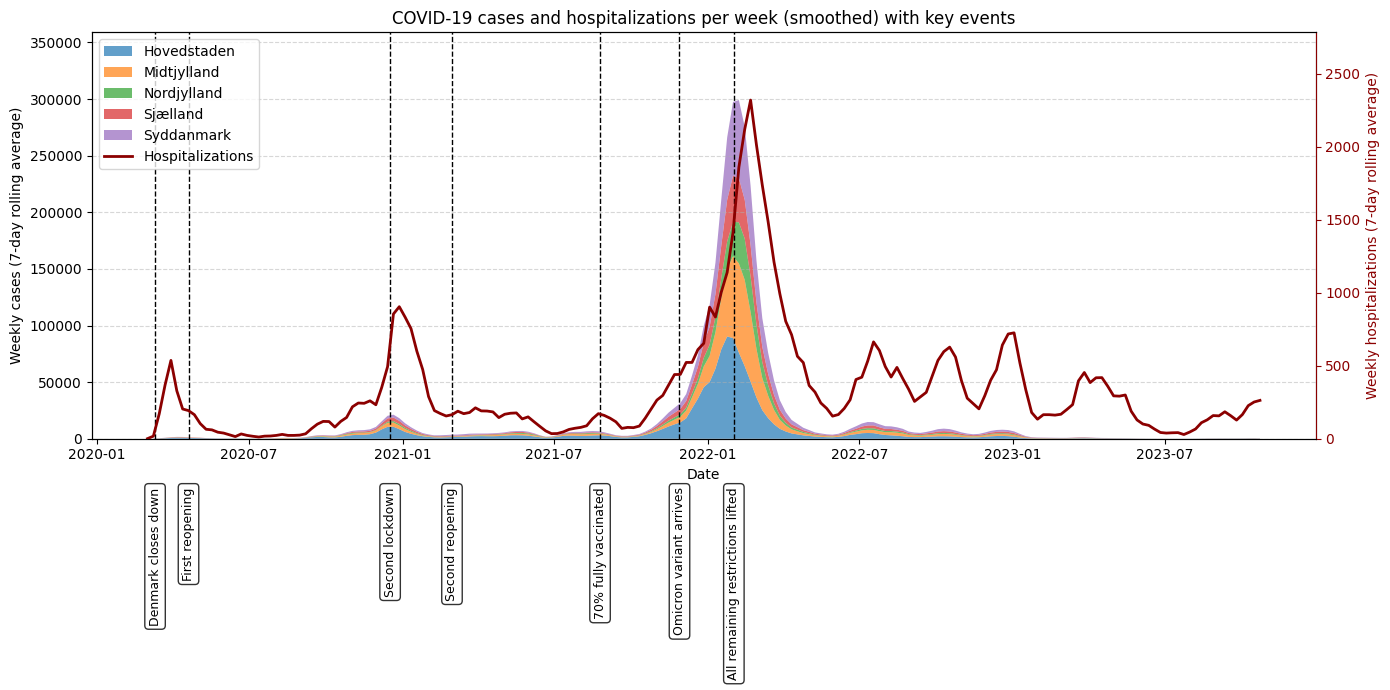

In [14]:
#stacked area plot with hospitalizations and legends
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
file_path_cases = r"C:\Users\eskil\OneDrive - Danmarks Tekniske Universitet\DTU uddannelse\Master - Semester 10\02806 Social Data Analysis and Visualization\Final project\Part 1\corona_data\overvaagningsdata\08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv"
file_path_hosp = r"C:\Users\eskil\OneDrive - Danmarks Tekniske Universitet\DTU uddannelse\Master - Semester 10\02806 Social Data Analysis and Visualization\Final project\Part 1\corona_data\overvaagningsdata\06_nye_indlaeggelser_pr_region_pr_dag.csv"

# COVID cases
df_cases = pd.read_csv(file_path_cases, sep=";", encoding="latin1")
df_cases["Dato"] = pd.to_datetime(df_cases["Dato"])
df_cases_grouped = df_cases.groupby(["Dato", "Region"])["Bekræftede tilfælde i alt"].sum().reset_index()
df_cases_pivot = df_cases_grouped.pivot(index="Dato", columns="Region", values="Bekræftede tilfælde i alt").fillna(0)
df_cases_weekly = df_cases_pivot.resample('W-MON').sum()
df_cases_smoothed = df_cases_weekly.rolling(window=3, center=True).mean()
df_cases_smoothed_clean = df_cases_smoothed.dropna(how='all')

# Hospitalizations
df_hosp = pd.read_csv(file_path_hosp, sep=";", encoding="latin1")
df_hosp["Dato"] = pd.to_datetime(df_hosp["Dato"])
df_hosp_grouped = df_hosp.groupby("Dato")["Indlæggelser"].sum()
df_hosp_weekly = df_hosp_grouped.resample('W-MON').sum()
#print(df_hosp_weekly)
# Events
events = {
    "2020-03-11": "Denmark closes down",
    "2020-04-20": "First reopening",
    "2020-12-17": "Second lockdown",
    "2021-03-01": "Second reopening",
    "2021-08-25": "70% fully vaccinated",
    "2021-11-28": "Omicron variant arrives",
    "2022-02-01": "All remaining restrictions lifted"
}

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Stack areas manually (no step to keep smooth look)
bottom = np.zeros(len(df_cases_smoothed_clean))
for region in df_cases_smoothed_clean.columns:
    ax1.fill_between(
        df_cases_smoothed_clean.index,
        bottom,
        bottom + df_cases_smoothed_clean[region],
        label=region,
        alpha=0.7
    )
    bottom += df_cases_smoothed_clean[region].values

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Weekly cases (7-day rolling average)")
ax1.set_title("COVID-19 cases and hospitalizations per week (smoothed) with key events")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Add event markers (place slightly lower to avoid title overlap)
ylim = ax1.get_ylim()
for date_str, label in events.items():
    date = pd.to_datetime(date_str)
    ax1.axvline(date, color='black', linestyle='--', lw=1, zorder=5)
    
    # Combine X in data coords (date) with Y in axes coords (fixed height)
    ax1.annotate(label,
                 xy=(date, 0),  # X = date in data coords, Y = 0 (bottom)
                 xytext=(0, -35),
                 textcoords='offset points',
                 xycoords=('data', 'axes fraction'),  # X in data, Y in axes fraction
                 rotation=90,
                 ha='center',
                 va='top',
                 fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))


# Twin axis: hospitalizations
ax2 = ax1.twinx()
hosp_line, = ax2.plot(
    df_hosp_weekly.index,
    df_hosp_weekly.values,
    color='darkred',
    linewidth=2,
    label="Hospitalizations",
    zorder=5
)

# Set proportional limits to align zero
ax1_max = df_cases_smoothed_clean.sum(axis=1).max() * 1.2
ax2_max = df_hosp_weekly.max() * 1.2

ax1.set_ylim(0, ax1_max)
ax2.set_ylim(0, ax2_max)

# Force alignment of zero between axes
scale_ratio = ax2_max / ax1_max
ax2.set_ylim(0, ax1_max * scale_ratio)

ax2.set_ylabel("Weekly hospitalizations (7-day rolling average)")
ax2.spines['right'].set_color('darkred')
ax2.yaxis.label.set_color('darkred')
ax2.tick_params(axis='y', colors='darkred')

ax2.spines['right'].set_color('darkred')
ax2.yaxis.label.set_color('darkred')
ax2.tick_params(axis='y', colors='darkred')

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = [hosp_line], ["Hospitalizations"]
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.tight_layout()
plt.show()


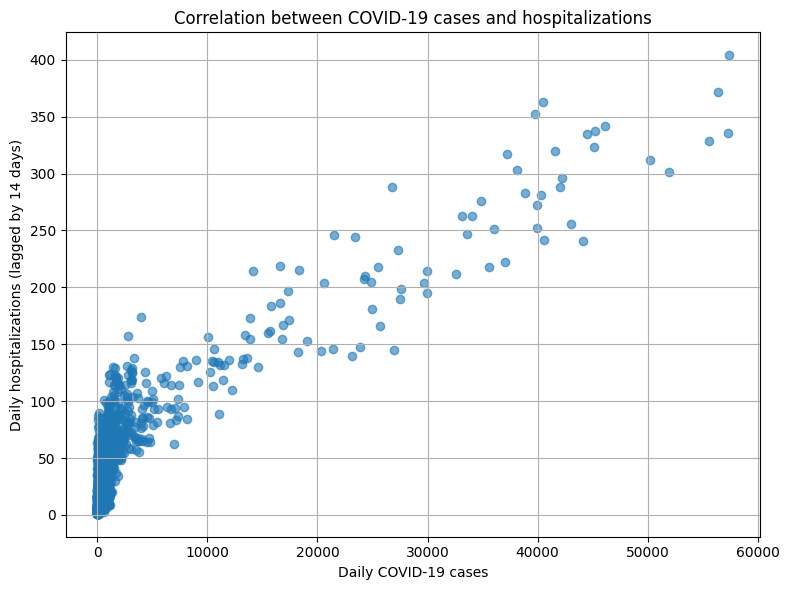

Pearson correlation (lag 14 days): 0.88


In [15]:
# Correlation between cases and hospitalizations
import pandas as pd
import matplotlib.pyplot as plt

# Set file paths
file_path_cases = r"C:\Users\eskil\OneDrive - Danmarks Tekniske Universitet\DTU uddannelse\Master - Semester 10\02806 Social Data Analysis and Visualization\Final project\Part 1\corona_data\overvaagningsdata\08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv"
file_path_hosp = r"C:\Users\eskil\OneDrive - Danmarks Tekniske Universitet\DTU uddannelse\Master - Semester 10\02806 Social Data Analysis and Visualization\Final project\Part 1\corona_data\overvaagningsdata\06_nye_indlaeggelser_pr_region_pr_dag.csv"

# Load cases
df_cases = pd.read_csv(file_path_cases, sep=";", encoding="latin1")
df_cases["Dato"] = pd.to_datetime(df_cases["Dato"])
df_cases_daily = df_cases.groupby("Dato")["Bekræftede tilfælde i alt"].sum()

# Load hospitalizations
df_hosp = pd.read_csv(file_path_hosp, sep=";", encoding="latin1")
df_hosp["Dato"] = pd.to_datetime(df_hosp["Dato"])
df_hosp_daily = df_hosp.groupby("Dato")["Indlæggelser"].sum()

# Apply lag (shift hospitalizations back in time)
lag_days = 14
df_hosp_lagged = df_hosp_daily.shift(-lag_days)

# Combine and align both series
df_combined = pd.DataFrame({
    "Cases": df_cases_daily,
    "Hospitalizations": df_hosp_lagged
}).dropna()

# Plot scatter
plt.figure(figsize=(8, 6))
plt.scatter(df_combined["Cases"], df_combined["Hospitalizations"], alpha=0.6)
plt.xlabel("Daily COVID-19 cases")
plt.ylabel(f"Daily hospitalizations (lagged by {lag_days} days)")
plt.title("Correlation between COVID-19 cases and hospitalizations")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print correlation
correlation = df_combined["Cases"].corr(df_combined["Hospitalizations"])
print(f"Pearson correlation (lag {lag_days} days): {correlation:.2f}")


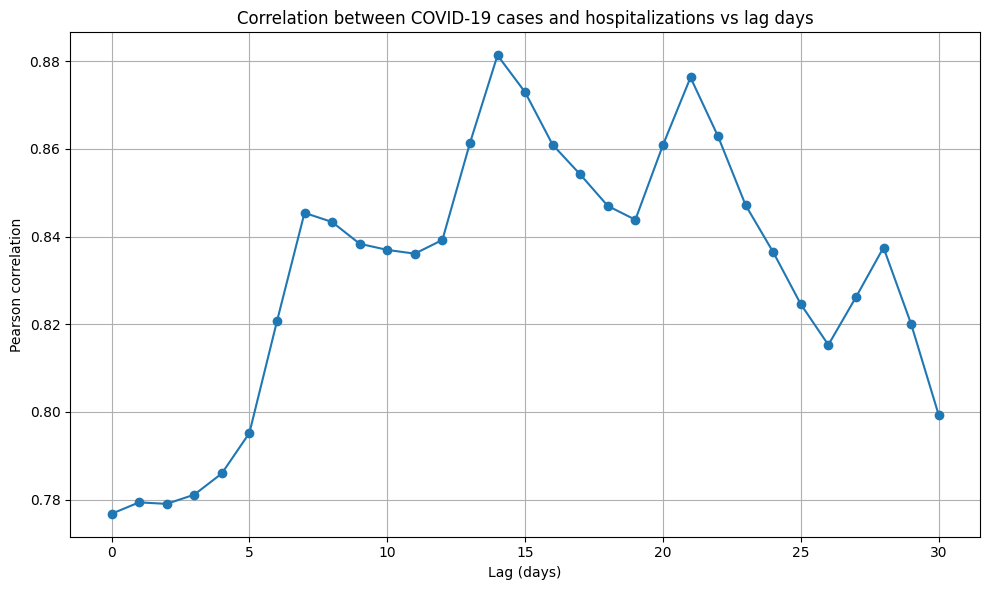

In [16]:
# Analisys of correlation vs days of lag
import pandas as pd
import matplotlib.pyplot as plt

# Set file paths
file_path_cases = r"C:\Users\eskil\OneDrive - Danmarks Tekniske Universitet\DTU uddannelse\Master - Semester 10\02806 Social Data Analysis and Visualization\Final project\Part 1\corona_data\overvaagningsdata\08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv"
file_path_hosp = r"C:\Users\eskil\OneDrive - Danmarks Tekniske Universitet\DTU uddannelse\Master - Semester 10\02806 Social Data Analysis and Visualization\Final project\Part 1\corona_data\overvaagningsdata\06_nye_indlaeggelser_pr_region_pr_dag.csv"

# Load cases
df_cases = pd.read_csv(file_path_cases, sep=";", encoding="latin1")
df_cases["Dato"] = pd.to_datetime(df_cases["Dato"])
df_cases_daily = df_cases.groupby("Dato")["Bekræftede tilfælde i alt"].sum()

# Load hospitalizations
df_hosp = pd.read_csv(file_path_hosp, sep=";", encoding="latin1")
df_hosp["Dato"] = pd.to_datetime(df_hosp["Dato"])
df_hosp_daily = df_hosp.groupby("Dato")["Indlæggelser"].sum()

# Initialize list to store correlations
lags = range(0, 31)
correlations = []

# Loop over lag days
for lag in lags:
    df_hosp_lagged = df_hosp_daily.shift(-lag)
    df_combined = pd.DataFrame({
        "Cases": df_cases_daily,
        "Hospitalizations": df_hosp_lagged
    }).dropna()
    corr = df_combined["Cases"].corr(df_combined["Hospitalizations"])
    correlations.append(corr)

# Plot correlation vs lag days
plt.figure(figsize=(10, 6))
plt.plot(lags, correlations, marker='o')
plt.xlabel("Lag (days)")
plt.ylabel("Pearson correlation")
plt.title("Correlation between COVID-19 cases and hospitalizations vs lag days")
plt.grid(True)
plt.tight_layout()
plt.show()


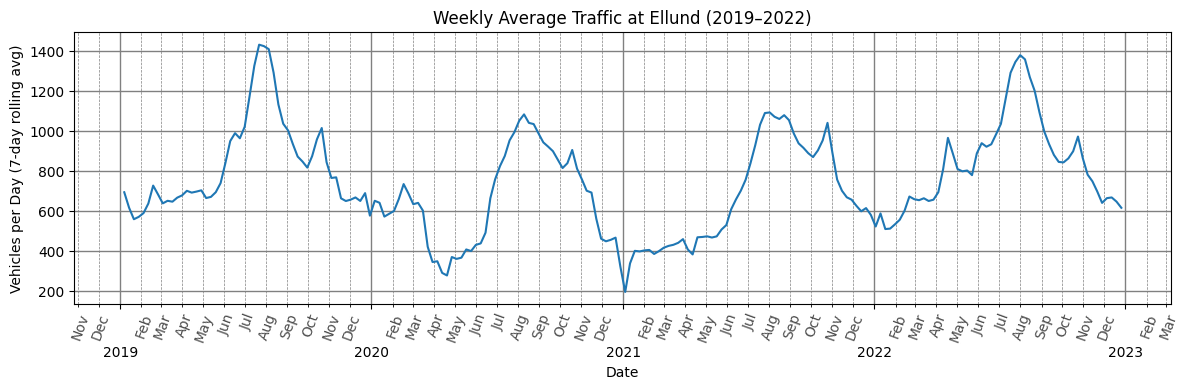

In [17]:
#Weekly average traffic at Ellund during corona
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Load & preprocess (as before)…
traffic_folder = os.path.join("trafik_data", "Ellund")
dfs = []
for fp in glob.glob(os.path.join(traffic_folder, "zst1109_*.csv")):
    d = pd.read_csv(fp, sep=";")
    d["Datum"] = pd.to_datetime(d["Datum"].astype(str), format="%y%m%d")
    d["dt"]    = d["Datum"] + pd.to_timedelta(d["Stunde"]-1, unit="h")
    d["total"] = d["KFZ_R1"] + d["KFZ_R2"]
    dfs.append(d)
all_traffic = pd.concat(dfs, ignore_index=True)

daily_avg = (all_traffic
             .set_index("dt")["total"]
             .resample("D").mean()
             .rolling(7).mean())
weekly_traf = daily_avg.resample("W-MON").mean().loc["2019":"2022"]

# 2) Plot with custom ticks
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(weekly_traf.index, weekly_traf.values)
ax.set_title("Weekly Average Traffic at Ellund (2019–2022)")
ax.set_xlabel("Date")
ax.set_ylabel("Vehicles per Day (7-day rolling avg)")

# Major ticks at the start of each year, labelled with the year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))

# Minor ticks at the first of each month, labelled with the month abbreviation
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

# Styling: bold grid lines for years, lighter for months
ax.grid(which='major', color='gray', linewidth=1.0)
ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Rotate month labels for readability
plt.setp(ax.xaxis.get_minorticklabels(), rotation=70, ha='right', alpha=0.7, rotation_mode='anchor')

plt.tight_layout()
plt.show()


Found files: ['trafik_data\\Ellund\\zst1109_2015.csv', 'trafik_data\\Ellund\\zst1109_2016.csv', 'trafik_data\\Ellund\\zst1109_2017.csv', 'trafik_data\\Ellund\\zst1109_2019.csv', 'trafik_data\\Ellund\\zst1109_2020.csv', 'trafik_data\\Ellund\\zst1109_2021.csv', 'trafik_data\\Ellund\\zst1109_2022.csv']


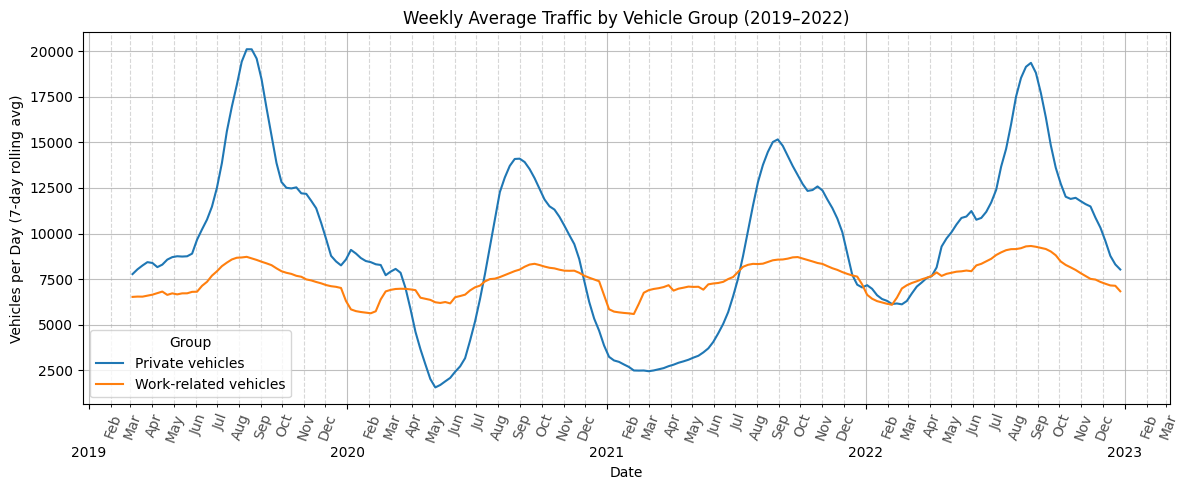

In [18]:
#weekly traffic by vehicle group
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Read all Ellund CSVs
traffic_folder = os.path.join("trafik_data", "Ellund")
files = glob.glob(os.path.join(traffic_folder, "zst1109_*.csv"))
print("Found files:", files)   # sanity check

dfs = []
for fp in files:
    d = pd.read_csv(fp, sep=";")
    d["Datum"] = pd.to_datetime(d["Datum"].astype(str), format="%y%m%d")
    d["dt"]    = d["Datum"] + pd.to_timedelta(d["Stunde"]-1, unit="h")
    # Combine R1 + R2 directions
    d["passenger_cars"] = d["Pkw_R1"].fillna(0) + d["Pkw_R2"].fillna(0)
    d["motorcycles"]    = d["Mot_R1"].fillna(0) + d["Mot_R2"].fillna(0)
    d["trucks"]         = d["Lkw_R1"].fillna(0) + d["Lkw_R2"].fillna(0)
    d["vans"]           = d["Lfw_R1"].fillna(0) + d["Lfw_R2"].fillna(0)
    d["private"]        = d["passenger_cars"] + d["motorcycles"]
    d["work"]           = d["trucks"] + d["vans"]
    dfs.append(d)

# 2) Concatenate and aggregate
all_traffic = pd.concat(dfs, ignore_index=True)
daily = all_traffic.set_index("dt")[["private","work"]].resample("D").sum()
weekly = daily.resample("W-MON").mean().rolling(7).mean()

# 3) Trim to 2019–2022
weekly = weekly.loc["2019-03-01":"2022-12-31"]

# 4) Plot
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(weekly.index, weekly["private"], label="Private vehicles")
ax.plot(weekly.index, weekly["work"],    label="Work-related vehicles")

ax.set_title("Weekly Average Traffic by Vehicle Group (2019–2022)")
ax.set_ylabel("Vehicles per Day (7-day rolling avg)")
ax.set_xlabel("Date")

# Major ticks at each new year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))

# Minor ticks at each month
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=70, ha='right', alpha=0.7, rotation_mode='anchor')

# Grid styling
ax.grid(which='major', alpha=0.8)
ax.grid(which='minor', linestyle='--', alpha=0.5)

ax.legend(title="Group")
plt.tight_layout()
plt.show()


In [19]:
# MOAP -> Mother Of All Plots, combined map of hopitalisation by region, total hospitalizations, Weekly traffic anomaly made from a 2015-2017 baseline and, and events with legends
# also has a slider to show the data over time, and a checkbox to show/hide the events
import os
import glob
import pandas as pd
import numpy as np
import geopandas as gpd
from bokeh.io import output_file, show
from bokeh.models import (
    ColumnDataSource, GMapOptions, Slider, CustomJS,
    Span, Range1d, CheckboxGroup, Div
)
from bokeh.plotting import gmap, figure
from bokeh.layouts import column, row
from datetime import datetime
from bokeh.palettes import Category10

# — PARAMETERS —
geojson_fp     = os.path.join("corona_data","regionsinddeling.geojson")
traffic_folder = os.path.join("trafik_data","Ellund")
hosp_fp        = os.path.join("corona_data","overvaagningsdata",
                              "03_bekraeftede_tilfaelde_doede_indlagte_pr_dag_pr_koen.csv")
API_KEY        = "My API Key"

# 1) Hospital map & series (unchanged) …
h3 = pd.read_csv(hosp_fp, sep=";", encoding="latin1")
h3["Prøvetagningsdato"] = pd.to_datetime(
    h3["Prøvetagningsdato"], dayfirst=True, errors="coerce"
)
h3 = h3.dropna(subset=["Prøvetagningsdato"])
weekly_reg = (
    h3.groupby(["Region","Prøvetagningsdato"])["Indlæggelser"]
      .sum().reset_index()
      .set_index("Prøvetagningsdato")
      .groupby("Region")
      .resample("W-MON")["Indlæggelser"]
      .sum().reset_index()
)
pivot_reg = weekly_reg.pivot(
    index="Prøvetagningsdato", columns="Region", values="Indlæggelser"
).fillna(0)
weeks, regions = list(pivot_reg.index), list(pivot_reg.columns)
alpha = (pivot_reg / pivot_reg.values.max()).values.tolist()

h_df = pd.read_csv(hosp_fp, sep=";", encoding="latin1")
h_df["Prøvetagningsdato"] = pd.to_datetime(
    h_df["Prøvetagningsdato"], dayfirst=True, errors="coerce"
)
h_df = h_df.dropna(subset=["Prøvetagningsdato"])
weekly_hosp = h_df.set_index("Prøvetagningsdato")["Indlæggelser"]\
                   .resample("W-MON").sum()
hosp_src = ColumnDataSource({
    "x": [d.timestamp()*1000 for d in weekly_hosp.index],
    "y": weekly_hosp.values
})

# 2) Traffic anomaly by private vs work
dfs = []
for fp in glob.glob(os.path.join(traffic_folder, "zst1109_*.csv")):
    d = pd.read_csv(fp, sep=";")
    d["Datum"] = pd.to_datetime(d["Datum"].astype(str), format="%y%m%d")
    d["dt"]    = d["Datum"] + pd.to_timedelta(d["Stunde"]-1, unit="h")
    # group counts
    d["private"] = d["Pkw_R1"].fillna(0) + d["Pkw_R2"].fillna(0) \
                 + d["Mot_R1"].fillna(0) + d["Mot_R2"].fillna(0)
    d["work"]    = d["Lkw_R1"].fillna(0) + d["Lkw_R2"].fillna(0) \
                 + d["Lfw_R1"].fillna(0) + d["Lfw_R2"].fillna(0)
    dfs.append(d)
all_ = pd.concat(dfs, ignore_index=True)

# daily -> 7-day rolling mean -> weekly
daily = (
    all_.set_index("dt")[["private","work"]]
        .resample("D")
        .sum()
        .rolling(7).mean()
)
weekly = daily.resample("W-MON").mean()

# baseline 2015-17 by ISO week
baseline = weekly["2015-01-01":"2017-12-31"]
baseline_by_wk = baseline.groupby(baseline.index.isocalendar().week).mean()

# subset and anomaly
subset = weekly["2019-01-01":"2022-12-31"]
iso_wks = subset.index.isocalendar().week
anom_priv = 100 * (subset["private"] - iso_wks.map(baseline_by_wk["private"])) \
               / iso_wks.map(baseline_by_wk["private"])
anom_work = 100 * (subset["work"]    - iso_wks.map(baseline_by_wk["work"]))  \
               / iso_wks.map(baseline_by_wk["work"])

traf_src = ColumnDataSource({
    "x":      [d.timestamp()*1000 for d in anom_priv.index],
    "y_priv": anom_priv.values,
    "y_work": anom_work.values
})

# 3) Map patches (unchanged) …
gdf = gpd.read_file(geojson_fp)
assert gdf.crs.to_string()=="EPSG:4326"
geo_names = [rec["navn"].replace("Region ","").strip() for _, rec in gdf.iterrows()]
order     = [regions.index(nm) for nm in geo_names]
first_alpha = alpha[0]

map_xs,map_ys,map_alpha = [],[],[]
for idx, rec in enumerate(gdf.itertuples()):
    polys = ([rec.geometry] if rec.geometry.type=="Polygon"
             else rec.geometry.geoms)
    xs, ys = [], []
    for poly in polys:
        x0,y0 = poly.exterior.xy
        xs.extend(list(x0)+[np.nan]); ys.extend(list(y0)+[np.nan])
    map_xs.append(xs); map_ys.append(ys)
    map_alpha.append(first_alpha[order[idx]])
map_src = ColumnDataSource(dict(xs=map_xs, ys=map_ys, alpha=map_alpha))

start = datetime(2020,1,1).timestamp()*1000
end   = datetime(2022,12,31).timestamp()*1000
time_range = Range1d(start=start, end=end)

# — Bokeh plots —

# Map
map_opts = GMapOptions(lat=56.0, lng=10.0, map_type="roadmap", zoom=6)
p_map = gmap(API_KEY, map_opts,
             title="Ellund & COVID Hospitalisations by Region",
             width=800, height=400)
p_map.patches("xs","ys", source=map_src,
              fill_color="red", fill_alpha="alpha", line_color="white")
p_map.circle(x=[9.40], y=[54.73], size=10,
             color="red", alpha=0.8, legend_label="Ellund station")

# Hospitalizations
p1 = figure(x_axis_type="datetime", x_range=time_range,
            width=400*2, height=350,
            title="Weekly COVID-19 Hospitalizations")
p1.line("x","y", source=hosp_src, line_width=2, color="red")
span1 = Span(location=hosp_src.data["x"][0], dimension="height",
             line_color="blue", line_dash="solid", line_width=3)
p1.add_layout(span1)

# Traffic anomaly
p2 = figure(x_axis_type="datetime", x_range=time_range,
            width=400*2, height=350,
            title="Weekly Traffic Anomaly vs. 2015-2017 Baseline (%)")
p2.line("x","y_priv", source=traf_src, line_width=2,
        color="steelblue", legend_label="Private")
p2.line("x","y_work", source=traf_src, line_width=2,
        color="darkorange", legend_label="Work")
span2 = Span(location=traf_src.data["x"][0], dimension="height",
             line_color="blue", line_dash="solid", line_width=3)
p2.add_layout(span2)
p2.legend.location = "top_left"

# Event annotations & HTML legend
events = {
    "2020-03-11":"Denmark closes down",
    "2020-04-20":"First reopening",
    "2020-12-17":"Second lockdown",
    "2021-03-01":"Second reopening",
    "2021-08-25":"70% fully vaccinated",
    "2021-11-28":"Omicron arrives",
    "2022-02-01":"Restrictions lifted"
}
colors = Category10[7]
event_spans = []
legend_html = ["<ul style='list-style:none; padding:0; margin:0;'>"]
for (date, label), color in zip(events.items(), colors):
    ts = datetime.fromisoformat(date).timestamp()*1000
    for plot in (p1, p2):
        sp = Span(location=ts, dimension="height",
                  line_color=color, line_dash="dashed", line_width=2,
                  visible=True)
        plot.add_layout(sp)
        event_spans.append(sp)
    legend_html.append(
        f"<li style='color:{color}; margin:4px 0;'>"
        f"<span style='display:inline-block; width:2em;'>■</span> {label}"
        f"</li>"
    )
legend_html.append("</ul>")
legend_div = Div(text="".join(legend_html), width=200)

# Slider
slider = Slider(start=0, end=len(weeks)-1, value=0, step=1, title="Week of pandemic",height=50)
slider.js_on_change("value", CustomJS(args=dict(
    ms=map_src, s1=span1, s2=span2,
    al=alpha, ts=[d.timestamp()*1000 for d in weeks], order=order
), code="""
    const i = cb_obj.value;
    const raw = al[i], reord = order.map(j=>raw[j]);
    ms.data['alpha'] = reord; ms.change.emit();
    s1.location = ts[i]; s2.location = ts[i];
"""))

# Checkbox & right panel
checkbox = CheckboxGroup(labels=["Show events"], active=[0],)


checkbox.js_on_change("active", CustomJS(args=dict(spans=event_spans), code="""
    const show = cb_obj.active.includes(0);
    for (let s of spans) s.visible = show;
"""))
right_panel = column(checkbox, legend_div, sizing_mode="fixed")

# Layout & output
layout = column(
    p_map,
    row(column(p1, p2), right_panel),
    slider
)
output_file("ellund_covid_map_hosp_traffic.html")
show(layout)


C:\Users\eskil\AppData\Local\Temp\ipykernel_32532\2036277073.py:27: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  h3["Prøvetagningsdato"] = pd.to_datetime(
C:\Users\eskil\AppData\Local\Temp\ipykernel_32532\2036277073.py:46: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  h_df["Prøvetagningsdato"] = pd.to_datetime(
C:\Users\eskil\AppData\Local\Temp\ipykernel_32532\2036277073.py:107: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  polys = ([rec.geometry] if rec.geometry.type=="Polygon"


## 6. Discussion
**What went well?**
* Clear linking of events to data dips, especially in the anomaly plot. - I was a bit worried that there would be no clear impact

* Slider + map coupling that highlights regional differences.

* Private vs. work split underscored differing human behaviors.

**What could be improved?**

* German data in a Danish analisys isn't ideal. So more relevant data would be nice

* I could have done a lot more based on the corona data. Its not included here, but i have age, gender, vaccination data... etc. the analisys could have been a lot more in depth based on that, but i had to draw a line somewhere.

* Compare traffic in different areas, i had a dream to maybe show e.g. more traffic around test-center etc. but data wasn't avaliable.

* Group work... I made everything for this final project by myself, as my one other group member had to proritize another course. This was a lot of work for one person, which has propably also led to mistakes here and there.\
*note: Im handing this in alone, Jakob will hand in something by himself as well.. i think.* 


## 7. Contributions
Eskil Rasmussen (s203817) Did everything

## 8. References

Segel, E., & Heer, J. (2010). Narrative visualization: Telling stories with data. http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf

Statens Serum Institut. (2024). Historiske COVID-19-opgørelser. https://www.ssi.dk/sygdomme-beredskab-og-forskning/sygdomsovervaagning/c/historiske-covid-19-opgoerelser

BASt – Bundesanstalt für Straßenwesen. (2022). Verkehrszaehlung A7 Ellund [Traffic counts, German A7 at Ellund]. https://www.bast.de/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Daten/2022_1/Jawe2022.html?cms_map=0&nn=1817946

Statens Serum Institut. (2022). COVID-19 tidslinje for 2020–2022 (lang version) [Policy timeline PDF]. https://www.ssi.dk/-/media/arkiv/subsites/covid19/presse/tidslinje-over-covid-19/covid-19-tidslinje-for-2020-2022-lang-version—version-1—april-2022.pdf

Bokeh Development Team. (2024). Bokeh: Python library for interactive visualization. https://bokeh.org/

Danish Agency for Data Supply and Infrastructure (Kortforsyningen). (n.d.). Region boundaries GeoJSON [Data file]. Retrieved from https://data-science.dk/datasat/gis/valg/danmarks-5-regioner-vektor/?srsltid=AfmBOopr5PD8FBrucCEXE1_0yAFkLAKDPLr9i00YO6KsozQesYATiTF9

Data-Science.dk. (n.d.). Danmarks 5 regioner (GeoJSON). Retrieved May 2025, from https://data-science.dk/datasat/gis/valg/danmarks-5-regioner-vektor/?srsltid=AfmBOopr5PD8FBrucCEXE1_0yAFkLAKDPLr9i00YO6KsozQesYATiTF9
